In [1]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
import os

from scipy.special import entr # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.entr.html
from keras.utils import to_categorical
import keras.metrics as metrics
from kf_impl import EKF_CV_MODEL
from lstm_impl import CombinedLSTM
import pdb
from utils import extract_data, sup_plot

import pandas as pd
import seaborn as sns

Using TensorFlow backend.


### Data Loading

In [2]:
def build_train_test_splits(pklfiles_to_process, num_pkl_folds=5):
    # Using a suboptimal approach here:
    # Just build a list of dictionaries, where entry_i 
    # corresponds to train split i.

    train_sets = []
    test_sets  = []
    
    
    inds = np.arange(num_pkl_folds)
    
    for hold_out_ind in inds:
        train_inds = np.delete(inds, hold_out_ind)
        
        train_set = {"history_traj_data" : None,
                     "future_traj_data"  : None,
                     "goal_position"     : None,
                     "one_hot_goal"      : None}

        test_set  = {"history_traj_data" : None,
                     "future_traj_data"  : None,
                     "goal_position"     : None,
                     "one_hot_goal"      : None}
        
        # Train Set
        for fold in train_inds:
            search_str = 'fold_%d' % fold
            search_res = np.argwhere([search_str in f for f in pklfiles_to_process])
            assert(len(search_res) == 1)
            file_num = search_res[0][0]
            history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process[file_num])

            if train_set['history_traj_data'] is None:
                train_set['history_traj_data'] = history_traj_data
                train_set['future_traj_data']  = future_traj_data
                train_set['goal_position']     = goals_position
                train_set['one_hot_goal']      = one_hot_goal         
            else:
                train_set['history_traj_data'] = np.append(train_set['history_traj_data'], history_traj_data, axis=0)
                train_set['future_traj_data']  = np.append(train_set['future_traj_data'], future_traj_data, axis=0)
                train_set['goal_position']     = np.append(train_set['goal_position'], goals_position, axis=0)
                train_set['one_hot_goal']      = np.append(train_set['one_hot_goal'], one_hot_goal, axis=0)

        # Test Set
        for fold in [hold_out_ind]:
            search_str = 'fold_%d' % fold
            search_res = np.argwhere([search_str in f for f in pklfiles_to_process])
            assert(len(search_res) == 1)
            file_num = search_res[0][0]
            history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process[file_num])

            if test_set['history_traj_data'] is None:
                test_set['history_traj_data'] = history_traj_data
                test_set['future_traj_data']  = future_traj_data
                test_set['goal_position']     = goals_position
                test_set['one_hot_goal']      = one_hot_goal         
            else:
                test_set['history_traj_data'] = np.append(test_set['history_traj_data'], history_traj_data, axis=0)
                test_set['future_traj_data']  = np.append(test_set['future_traj_data'], future_traj_data, axis=0)
                test_set['goal_position']     = np.append(test_set['goal_position'], goals_position, axis=0)
                test_set['one_hot_goal']      = np.append(test_set['one_hot_goal'], one_hot_goal, axis=0)
                
        train_sets.append(train_set)
        test_sets.append(test_set)
        
    return train_sets, test_sets

### Metrics

In [3]:
def weighted_dist_by_timestep(goal_pred, traj_pred_dict, traj_actual):
    # M = # of instances, N = time horizon, 2 (xy) 
    M = traj_pred_dict[0].shape[0]
    N = traj_pred_dict[0].shape[1]
    
    weighted_sum = np.zeros((M, N))
    num_pred_traj = len(traj_pred_dict.keys())
    top_k_probs = -np.sort(-goal_pred, axis=1)[:,:num_pred_traj]
    
    for k in range(num_pred_traj):
        # key = 0 
        traj_pred_k = traj_pred_dict[k] # M by N by 2
        diff = traj_pred_k - traj_actual # M by N by 2
        diff_xy_norm = np.linalg.norm(diff, axis=2) # M by N

        for i in range(N):
            diff_xy_norm[:,i] *= top_k_probs[:,k]
        
        weighted_sum += diff_xy_norm
    return np.mean(weighted_sum, axis=0)

def dist_by_timestep(traj_pred_dict, traj_actual):
    # returns avg, min, max distance error across each timestep
    diff = traj_pred_dict[0] - traj_actual # N by N_pred by 2
    diff_xy_norm = np.linalg.norm(diff, axis=2)
    return np.mean(diff_xy_norm, axis=0), np.min(diff_xy_norm, axis = 0), np.max(diff_xy_norm, axis=0)

def top_k_accuracy(goal_pred, goal_actual, k=1):
    # returns empirical probability of the real goal being contained
    # in the top k most likely goal set from goal_pred.
    return np.mean(metrics.top_k_categorical_accuracy(goal_actual, goal_pred, k=k))

def mean_entropy(goal_pred):
    # returns the avg. entropy of the goal prediction dist.
    # higher entropy indicates more uncertain predictions
    N = goal_pred.shape[0]
    
    entr_matrix = entr(goal_pred)
    entr_by_instance = np.sum(entr_matrix, axis=1) #entropy by snippet
    return np.mean(entr_by_instance)

### Train and Save Models and Results

In [4]:
# Construct the evaluation datasets.
MODE = 'TRAIN' # 'TRAIN' or 'LOAD'
res_filename = 'model_comparison_dict.pkl'

pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
train_sets, test_sets = build_train_test_splits(pklfiles_to_process, num_pkl_folds=5)

# Build the model bank.
models = [EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)]
names =  ['EKF_CV']

# Create saving directories.
if not os.path.exists('./model'):
    os.makedirs('./model')
if not os.path.exists('./results'):
    os.makedirs('./results')

# Build Trajectory Model
# history_shape = train_sets[0]['history_traj_data'].shape
# goal_position_shape = train_sets[0]['goal_position'].shape
# one_hot_goal_shape = train_sets[0]['one_hot_goal'].shape
# future_shape = train_sets[0]['future_traj_data'].shape
# Hard coded for now, need to make this more robust:
history_shape       = (None, 5, 3)
goal_position_shape = (None, 32*3)
one_hot_goal_shape  = (None, 32+1)
future_shape        = (None, 20, 2)
hidden_dim = 100
top_k_goal = [0,1,2]

for gamma in [0.001, 0.1, 1.0]:
    for beta in [0.001, 0.1, 1.0]:
        models.append(
            CombinedLSTM(history_shape,
                         goal_position_shape,
                         one_hot_goal_shape,
                         future_shape,
                         hidden_dim,
                         beta=beta,
                         gamma=gamma,
                         use_goal_info=True)
        )
    
        names.append('LSTM_b%.3f_g%.3f' % (beta, gamma)) # ground truth goal, anyone can be used for traj LSTM

models.append(
    CombinedLSTM(history_shape,
                 goal_position_shape,
                 one_hot_goal_shape,
                 future_shape,
                 hidden_dim,
                 beta=beta,
                 gamma=gamma,
                 use_goal_info=False)
) # no goal provided, beta gamma irrelevant, don't use for goal classification

names.append('LSTM_no_goal')
            
model_res_dict = {} # same indexing/length as names/models
if MODE is 'TRAIN':
    for name, model in zip(names, models):
        metric_dict = {}
        metric_dict['train'] = {'N_instances'   : [],
                                'traj_dist_vs_N': [],   # no goal
                                'wtraj_dist_vs_N': [],  # weighted, multimodal
                                'gtraj_dist_vs_N': [],  # gt
                                'goal_top_1_acc': [], 
                                'goal_top_3_acc': [],
                                'goal_top_5_acc': [],
                                'goal_entropy'  : []}
        metric_dict['test']  = {'N_instances'   : [],
                                'traj_dist_vs_N': [],   # no goal
                                'wtraj_dist_vs_N': [],  # weighted, multimodal
                                'gtraj_dist_vs_N': [],  # gt
                                'goal_top_1_acc': [], 
                                'goal_top_3_acc': [],
                                'goal_top_5_acc': [],
                                'goal_entropy'  : []}

        for i_fold, (train_set, test_set) in enumerate(zip(train_sets, test_sets)):
            print('Training %s, Fold %d' % (name, i_fold))
            model.fit(train_set, test_set)
            model.save('./model/%s_fold%d' % (name, i_fold))

            for tkey, tset in zip(['train', 'test'], [train_set, test_set]):

                goal_pred, traj_pred_dict = model.predict(tset) # either no goal or ground truth
                N_instances = goal_pred.shape[0]
                
                if 'no_goal' in name or 'EKF_CV' in name:
                    # just populate the traj_dist_vs_N
                    meand, mind, maxd = dist_by_timestep(traj_pred_dict, tset['future_traj_data'][:,:,:2])
                    metric_dict[tkey]['traj_dist_vs_N'].append(meand)
                else:
                    meand, mind, maxd = dist_by_timestep(traj_pred_dict, tset['future_traj_data'][:,:,:2])
                    metric_dict[tkey]['gtraj_dist_vs_N'].append(meand)
                    
                    goal_pred, traj_pred_dict = model.predict(tset, top_k_goal)
                    wmeand = weighted_dist_by_timestep(goal_pred, traj_pred_dict, tset['future_traj_data'][:,:,:2])
                    metric_dict[tkey]['wtraj_dist_vs_N'].append(wmeand)
                    # populate gtraj_dist_vs_N (gt)
                    # and do multimodal
                
                t1 = top_k_accuracy(goal_pred, tset['one_hot_goal'], k=1)
                t3 = top_k_accuracy(goal_pred, tset['one_hot_goal'], k=3)
                t5 = top_k_accuracy(goal_pred, tset['one_hot_goal'], k=5)

                ment = mean_entropy(goal_pred)
                metric_dict[tkey]['N_instances'].append(N_instances)
                metric_dict[tkey]['goal_top_1_acc'].append(t1)
                metric_dict[tkey]['goal_top_3_acc'].append(t3)
                metric_dict[tkey]['goal_top_5_acc'].append(t5)
                metric_dict[tkey]['goal_entropy'].append(ment)

                # TODO: save predictions/labels?

        model_res_dict[name] = metric_dict

    # save the model_res_dict to ./results
    filename = 'model_comparison_dict.pkl'
    pickle.dump(model_res_dict, open('./results/%s' % res_filename, 'wb'))
elif MODE is 'LOAD':
    # TODO: maybe load models if needed?
    model_res_dict = pickle.load(open('./results/%s' % res_filename, 'rb'))
else:
    raise ValueError("Invalid mode!")

Training EKF_CV, Fold 0
Training EKF_CV, Fold 1
Training EKF_CV, Fold 2
Training EKF_CV, Fold 3
Training EKF_CV, Fold 4
Training LSTM_b0.001_g0.001, Fold 0
Training LSTM_b0.001_g0.001, Fold 1
Training LSTM_b0.001_g0.001, Fold 2
Training LSTM_b0.001_g0.001, Fold 3
Training LSTM_b0.001_g0.001, Fold 4
Training LSTM_b0.100_g0.001, Fold 0
Training LSTM_b0.100_g0.001, Fold 1
Training LSTM_b0.100_g0.001, Fold 2
Training LSTM_b0.100_g0.001, Fold 3
Training LSTM_b0.100_g0.001, Fold 4
Training LSTM_b1.000_g0.001, Fold 0
Training LSTM_b1.000_g0.001, Fold 1
Training LSTM_b1.000_g0.001, Fold 2
Training LSTM_b1.000_g0.001, Fold 3
Training LSTM_b1.000_g0.001, Fold 4
Training LSTM_b0.001_g0.100, Fold 0
Training LSTM_b0.001_g0.100, Fold 1
Training LSTM_b0.001_g0.100, Fold 2
Training LSTM_b0.001_g0.100, Fold 3
Training LSTM_b0.001_g0.100, Fold 4
Training LSTM_b0.100_g0.100, Fold 0
Training LSTM_b0.100_g0.100, Fold 1
Training LSTM_b0.100_g0.100, Fold 2
Training LSTM_b0.100_g0.100, Fold 3
Training LSTM_b0

### Analysis and Visualization

In [5]:
# Get the data
pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

file_num = 0

pklfile = pklfiles_to_process[file_num]

vtest_set  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}
vtest_set_kf  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}

vtest_set['history_traj_data'], vtest_set['future_traj_data'], vtest_set['goal_position'], vtest_set['one_hot_goal'], traj_idx = extract_data(pklfile, full_traj=True, crop_traj=True)
vtest_set_kf['history_traj_data'], vtest_set_kf['future_traj_data'], vtest_set_kf['goal_position'], vtest_set_kf['one_hot_goal'], traj_idx_kf = extract_data(pklfile, full_traj=True, crop_traj=False)

for name, model in zip(names, models):
    if 'EKF_CV' in name:
        goal_pred, traj_pred_dict = model.predict(vtest_set_kf)
    elif 'no_goal' in name:
        continue
    else:
        goal_pred, traj_pred_dict = model.predict(vtest_set, top_k_goal=top_k_goal)
        
    sup_plot(name, vtest_set, traj_idx, goal_pred, traj_pred_dict, limit=2)

Found 6 pkl files: ['./dataset/pilot_dataset_12_08_13_02_29.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_0.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_1.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_2.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_3.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_4.pkl']
EKF_CV: Start processing trajectory # 000 .....
EKF_CV: Trajectory # 000 movie saved successfully.
EKF_CV: Start processing trajectory # 001 .....
EKF_CV: Trajectory # 001 movie saved successfully.
LSTM_b0.001_g0.001: Start processing trajectory # 000 .....
LSTM_b0.001_g0.001: Trajectory # 000 movie saved successfully.
LSTM_b0.001_g0.001: Start processing trajectory # 001 .....
LSTM_b0.001_g0.001: Trajectory # 001 movie saved successfully.
LSTM_b0.100_g0.001: Start processing trajectory # 000 .....
LSTM_b0.100_g0.001: Trajectory # 000 movie saved successfully.
LSTM_b0.100_g0.001: Start processing trajectory # 001 .....
LSTM_b0.100_g0.001: Trajectory # 001 movie

            Model  Split  Fold  Timestep  Distance Error
0          EKF_CV  train   0.0       0.0        0.047729
1          EKF_CV  train   0.0       1.0        0.077631
2          EKF_CV  train   0.0       2.0        0.109347
3          EKF_CV  train   0.0       3.0        0.147590
4          EKF_CV  train   0.0       4.0        0.189868
..            ...    ...   ...       ...             ...
595  LSTM_no_goal   test   4.0      15.0        0.720215
596  LSTM_no_goal   test   4.0      16.0        0.785586
597  LSTM_no_goal   test   4.0      17.0        0.850220
598  LSTM_no_goal   test   4.0      18.0        0.919617
599  LSTM_no_goal   test   4.0      19.0        0.991756

[600 rows x 5 columns]


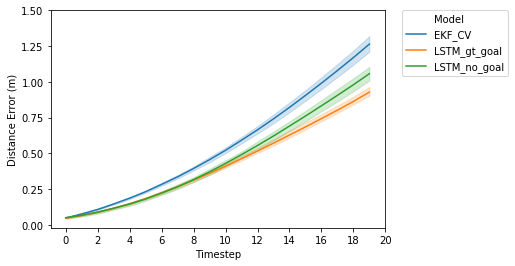

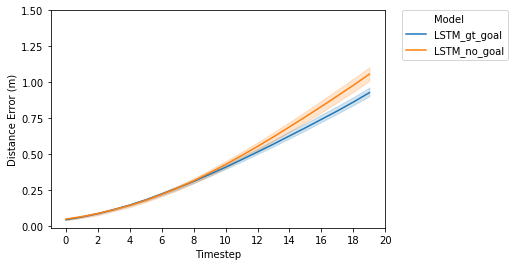

In [13]:
# PLOT 1: timestep vs. mean distance error
import pandas as pd
import seaborn as sns
data_list = []
timesteps = np.arange(20) # TODO: hard coded for now, change later.

for model in model_res_dict.keys():
    for split in model_res_dict[model].keys(): 
        # train/test
        if 'no_goal' in model:
            name = model
            traj_dist_vs_N = model_res_dict[model][split]['traj_dist_vs_N']
        elif 'EKF' in model:
            name = model
            traj_dist_vs_N = model_res_dict[model][split]['traj_dist_vs_N']
            # hack to only get ground truth goal based traj. pred once
        elif 'b0.100_g0.100' in model:
            name = 'LSTM_gt_goal'
            traj_dist_vs_N = model_res_dict[model][split]['gtraj_dist_vs_N']
        else:
            continue
    
        for i_fold, td in enumerate(traj_dist_vs_N):
            for j_timestep, dist_timestep in enumerate(td):
                data_list.append([name, split, i_fold, j_timestep, dist_timestep])
            
traj_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'Timestep', 'Distance Error'],dtype=float)
print(traj_df)

ax = sns.lineplot(x="Timestep", y="Distance Error", hue="Model", data=traj_df[traj_df.Split == 'test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

ax = sns.lineplot(x="Timestep", y="Distance Error", hue="Model", data=traj_df[(traj_df.Split == 'test') & \
                                                                              (traj_df.Model != 'EKF_CV')])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

                   Model Split  Fold  Timestep  Weighted Distance Error
100   LSTM_b0.001_g0.001  test   0.0       0.0                 0.047464
101   LSTM_b0.001_g0.001  test   0.0       1.0                 0.058537
102   LSTM_b0.001_g0.001  test   0.0       2.0                 0.076034
103   LSTM_b0.001_g0.001  test   0.0       3.0                 0.106495
104   LSTM_b0.001_g0.001  test   0.0       4.0                 0.136439
...                  ...   ...   ...       ...                      ...
2095        LSTM_gt_goal  test   4.0      15.0                 0.676487
2096        LSTM_gt_goal  test   4.0      16.0                 0.732214
2097        LSTM_gt_goal  test   4.0      17.0                 0.788521
2098        LSTM_gt_goal  test   4.0      18.0                 0.851912
2099        LSTM_gt_goal  test   4.0      19.0                 0.920045

[1100 rows x 5 columns]


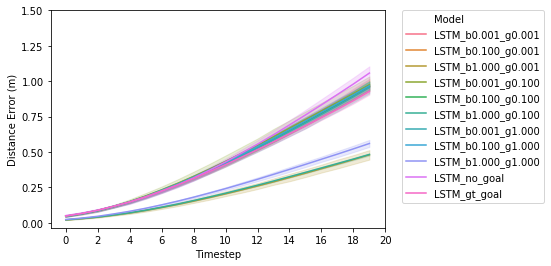

/home/govvijay/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


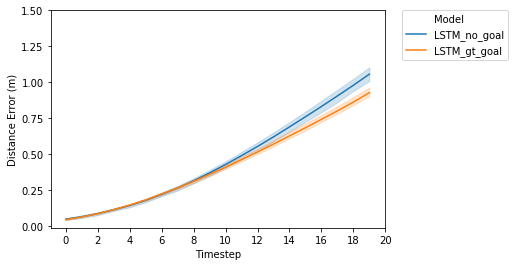

In [21]:
# PLOT 2: timestep vs. weighted mean distance error
import pandas as pd
import seaborn as sns
data_list = []
timesteps = np.arange(20) # TODO: hard coded for now, change later.

for model in model_res_dict.keys():
    for split in model_res_dict[model].keys(): 
        # train/test
        if 'no_goal' in model:
            name = model
            traj_dist_vs_N = model_res_dict[model][split]['traj_dist_vs_N']
        elif 'EKF' in model:
            continue
        else:
            name = model
            traj_dist_vs_N = model_res_dict[model][split]['wtraj_dist_vs_N']  
            
        for i_fold, td in enumerate(traj_dist_vs_N):
            for j_timestep, dist_timestep in enumerate(td):
                data_list.append([name, split, i_fold, j_timestep, dist_timestep])

gtraj_dist_vs_N_test = model_res_dict['LSTM_b0.100_g0.100']['test'] ['gtraj_dist_vs_N'] 
for i_fold, td in enumerate(gtraj_dist_vs_N_test):
    for j_timestep, dist_timestep in enumerate(td):
        data_list.append(['LSTM_gt_goal', 'test', i_fold, j_timestep, dist_timestep])

gtraj_dist_vs_N_train = model_res_dict['LSTM_b0.100_g0.001']['train']['gtraj_dist_vs_N'] 
for i_fold, td in enumerate(gtraj_dist_vs_N_train):
    for j_timestep, dist_timestep in enumerate(td):
        data_list.append(['LSTM_gt_goal', 'train', i_fold, j_timestep, dist_timestep])
                
traj_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'Timestep', 'Weighted Distance Error'],dtype=float)
traj_df_test = traj_df[traj_df.Split == 'test']
print(traj_df_test)

ax = sns.lineplot(x="Timestep", y="Weighted Distance Error", hue="Model", data=traj_df_test)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

ax = sns.lineplot(x="Timestep", y="Weighted Distance Error", hue="Model", data=traj_df_test[(traj_df.Model == 'LSTM_no_goal') | 
                                                                                            (traj_df.Model == 'LSTM_gt_goal')])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

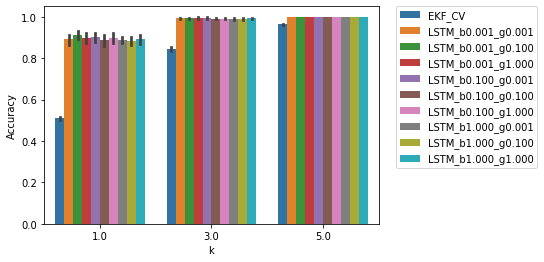

In [12]:
# PLOT 3: Top K accuracy
import pandas as pd
import seaborn as sns
data_list = []
# timesteps = np.arange(20) # TODO: hard coded for now, change later.

for model in model_res_dict.keys():
    if 'no_goal' in model:
        continue
    for split in model_res_dict[model].keys():
        
        
        #train/test
        
        goal_top_1_acc = model_res_dict[model][split]['goal_top_1_acc']
        goal_top_3_acc = model_res_dict[model][split]['goal_top_3_acc']
        goal_top_5_acc = model_res_dict[model][split]['goal_top_5_acc']
#         goal_entropy   = model_res_dict[model][split]['goal_entropy']
        
        for i_fold, (t1, t3, t5) in enumerate(zip(goal_top_1_acc, 
                                                       goal_top_3_acc,
                                                       goal_top_5_acc)):
            data_list.append([model, split, i_fold, 1, t1])
            data_list.append([model, split, i_fold, 3, t3])
            data_list.append([model, split, i_fold, 5, t5])
            
goal_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'k', 'Accuracy'],dtype=float)
goal_test_df = goal_df[goal_df.Split == 'test']

# Make a bar chart out of this.
ax = sns.barplot(x='k', y='Accuracy', hue='Model', data=goal_df.sort_values(by=['Model']))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()  


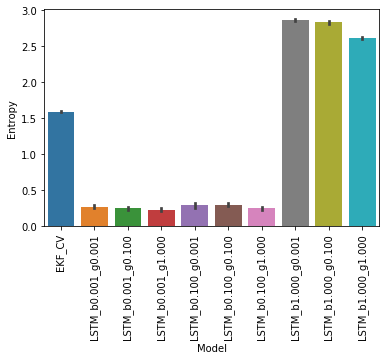

In [9]:
# PLOT 4: Entropy
import pandas as pd
import seaborn as sns
data_list = []

for model in model_res_dict.keys():
    if 'no_goal' in model:
        continue
    for split in model_res_dict[model].keys():
        #train/test
        goal_entropy   = model_res_dict[model][split]['goal_entropy']
        
        for i_fold, ent in enumerate(goal_entropy):
            data_list.append([model, split, i_fold, ent])
            
goal_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'Entropy'],dtype=float)
goal_test_df = goal_df[goal_df.Split == 'test']

# Make a bar chart out of this.
ax = sns.barplot(x='Model', y='Entropy', data=goal_df.sort_values(by=['Model']))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation='vertical')
plt.show()  
